In [21]:
from diffusers import StableDiffusionXLPipeline, DiffusionPipeline
import torch
from PIL import Image
import os

In [28]:
def generate_image(
    model_path,
    prompt,
    num_inference_steps=50,
    guidance_scale_base=7,
    guidance_scale_refiner=4,
    high_noise_frac = 0.9,
    seed=None
):    
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        
    # Load the fine-tuned model
    base = DiffusionPipeline.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        use_safetensors=True
    ).to("cuda")

    refiner = DiffusionPipeline.from_pretrained(
        "stabilityai/stable-diffusion-xl-refiner-1.0",
        text_encoder_2=base.text_encoder_2,
        vae=base.vae,
        torch_dtype=torch.float16,
        use_safetensors=True,
        variant="fp16",
    )
    refiner.to("cuda")
    
    # Generate the image
    image = base(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        denoising_end=high_noise_frac,
        guidance_scale=guidance_scale_base,
        output_type="latent",
    ).images
    image = refiner(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        denoising_start=high_noise_frac,
        guidance_scale=guidance_scale_refiner,
        image=image,
    ).images[0]
        
    # Clear GPU memory
    del base
    del refiner
    torch.cuda.empty_cache()
    
    return image

In [31]:
model_path = "/workspace/fine_tuned_sdxl"
prompt = """
       A beautifully hand-drawn garden gnome decoration in a whimsical illustrated style. Full body.
       The lines are slightly sketchy with smooth, painterly textures, evoking a warm and artistic aesthetic. The colors are vibrant yet slightly soft, blending like traditional colored pencil or watercolor artwork.
       The background is plain white for product display.
    """

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

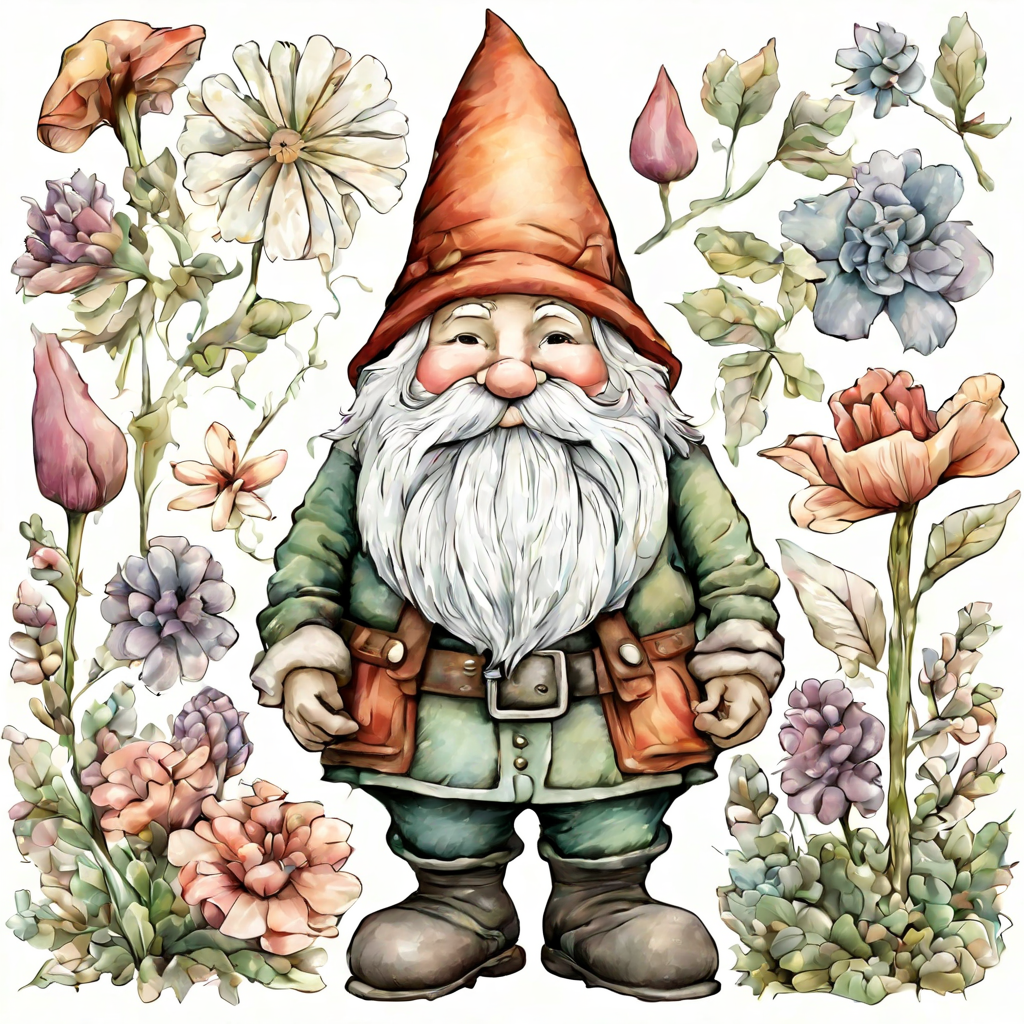

In [32]:
generate_image(
    model_path=model_path,
    prompt=prompt,
    num_inference_steps=40,
    guidance_scale_base=7,
    guidance_scale_refiner=4,
    high_noise_frac=0.9
)